# Why Log Returns? A Mathematical Foundation

**Understanding the Correct Transformation for Financial Time Series**

Before we can detect market regimes, we must answer a fundamental question:

> **How should we transform price data for statistical analysis?**

This notebook provides the mathematical proof for why **log returns** are the theoretically correct choice.

## Table of Contents

1. [The Two Competing Approaches](#approaches)
2. [Data Collection](#data)
3. [Visual Comparison](#visual)
4. [Property 1: Stationarity](#stationarity)
5. [Property 2: Time Additivity](#additivity)
6. [Property 3: Scale Invariance](#scale)
7. [Property 4: Symmetric Treatment](#symmetric)
8. [Property 5: Cross-Asset Comparability](#comparability)
9. [Distribution Properties](#distribution)
10. [Conclusion](#conclusion)

---

**Note**: This notebook contains NO regime detection. We're proving mathematical properties only.

The next notebook will show how to use these log returns for HMM-based regime detection.

In [1]:
# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Statistical tools
from scipy import stats
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.stats.diagnostic import het_arch

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette(sns.color_palette())

print("Imports complete")

Imports complete


## 1. The Two Competing Approaches <a name="approaches"></a>

When transforming price data $P_t$ into returns, we have two options:

### Simple (Percentage) Returns

$$r_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1$$

### Log Returns

$$R_t = \log\left(\frac{P_t}{P_{t-1}}\right) = \log(P_t) - \log(P_{t-1})$$

### Why This Matters

Statistical models (including HMMs) require **stationary** observations. The wrong choice breaks fundamental assumptions.

We'll prove that log returns satisfy **5 critical mathematical properties** that percentage returns do not.

## 2. Data Collection <a name="data"></a>

We'll use 4 assets with different characteristics:

- **SPY**: S&P 500 ETF (market benchmark, ~\$500)
- **AAPL**: Apple (~\$180)
- **TSLA**: Tesla (~\$250, high volatility)
- **KO**: Coca-Cola (~\$60, defensive)

The different price levels ranging from \$60 to \\$500 will demonstrate scale invariance.

In [2]:
# Download 2 years of data
tickers = ['SPY', 'AAPL', 'TSLA', 'KO']
end_date = datetime.now()
start_date = end_date - timedelta(days=730)

print(f"Downloading data from {start_date.date()} to {end_date.date()}\n")

data = {}
for ticker in tickers:
    print(f"Downloading {ticker}...", end=' ')
    df = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
    data[ticker] = df
    price_delta = df['Close'].max()-df['Close'].min()
    print(f"({len(df)} days, price range: ${price_delta[ticker]:.2f})")

print(f"\nDownloaded {len(tickers)} assets")



Downloaded 4 assets


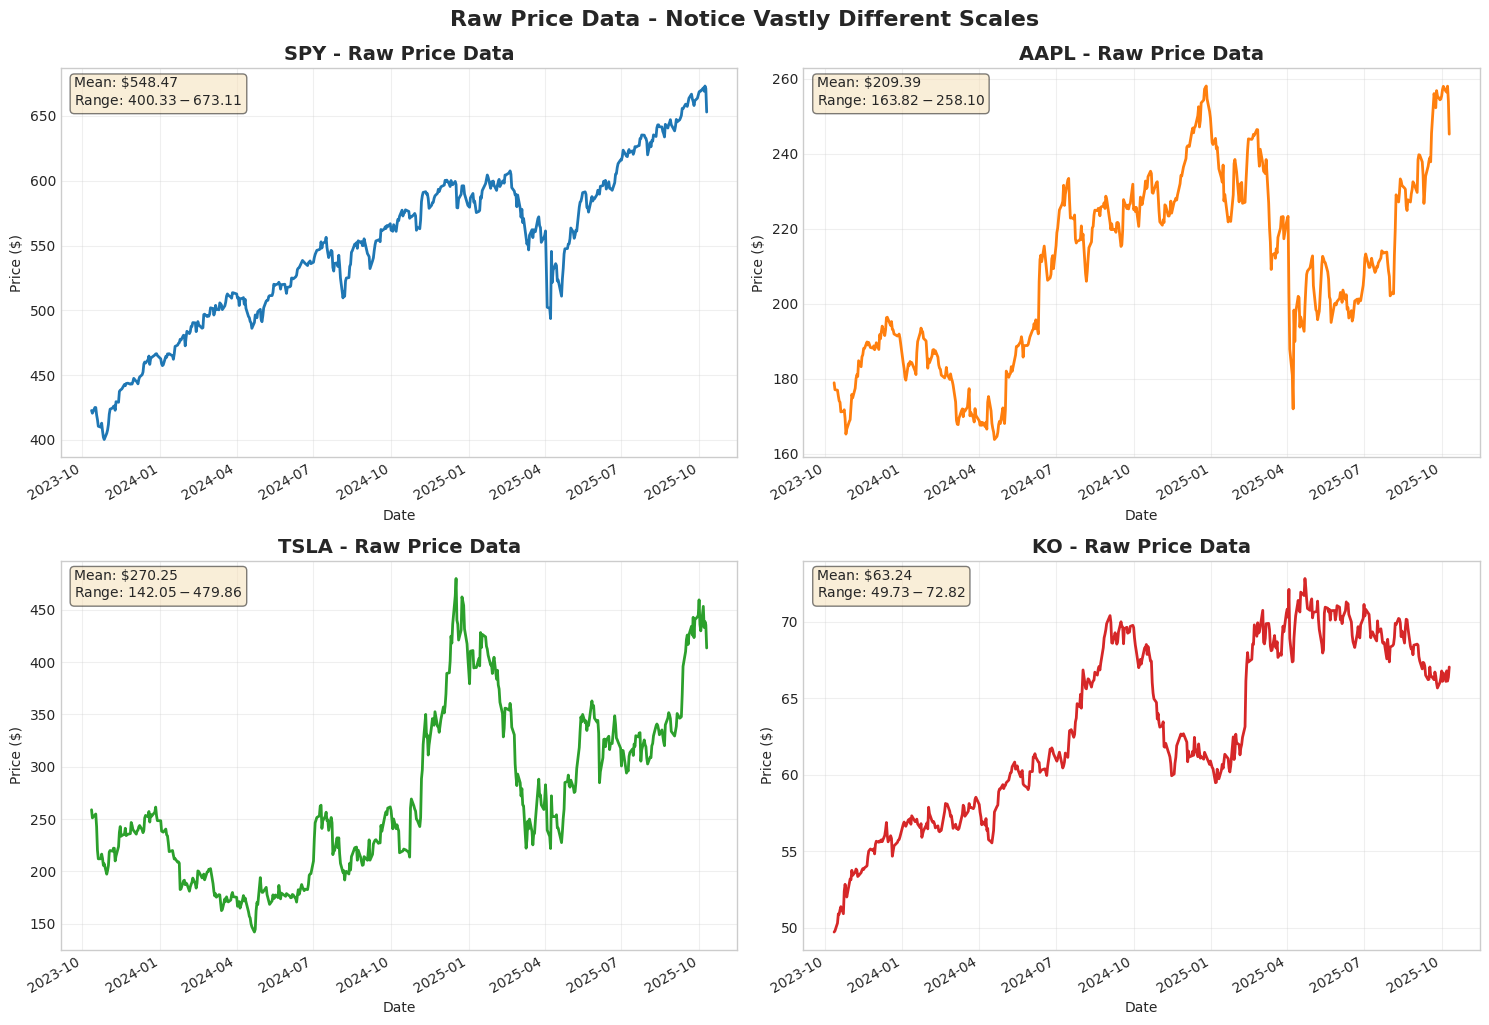

In [3]:
# Visualize raw prices to show scale differences
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for idx, ticker in enumerate(tickers):
    ax = axes[idx]
    prices = data[ticker]['Close'].squeeze()
    prices.plot(ax=ax, linewidth=2, color=f'C{idx}')
    
    ax.set_title(f'{ticker} - Raw Price Data', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price ($)')
    ax.grid(True, alpha=0.3)
    
    # Add price statistics
    mean_price = prices.mean()
    min_price = prices.min()
    max_price = prices.max()
    
    ax.text(0.02, 0.98, 
            f'Mean: ${mean_price:.2f}\nRange: ${min_price:.2f}-${max_price:.2f}',
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.suptitle('Raw Price Data - Notice Vastly Different Scales', 
             y=1.02, fontsize=16, fontweight='bold')
plt.show()

### Note that the price disparities create a problem when comparing percentages

## 3. Visual Comparison <a name="visual"></a>

Let's calculate both types of returns and compare them visually.

In [4]:
# Demonstration: Correct vs Incorrect Display of Log Returns
ticker = 'SPY'
prices = data[ticker]['Close'].squeeze()
log_returns = np.log(prices / prices.shift(1)).dropna()
simple_returns = prices.pct_change().dropna()

print("HOW TO DISPLAY LOG RETURNS")
print("=" * 80)

# Calculate statistics
log_mean = log_returns.mean()
log_std = log_returns.std()
simple_mean = simple_returns.mean()
simple_std = simple_returns.std()

print("\n1. MEAN (Expected Daily Return)")
print("-" * 80)
print(f"   Log return mean (log space):        {log_mean:.6f}")
print(f"   Simple return mean:                 {simple_mean:.6f}")
print(f"\n   CORRECT:   (e^{log_mean:.6f} - 1) * 100 = {(np.exp(log_mean) - 1) * 100:.4f}%")
print(f"   WRONG:     {log_mean:.6f} * 100 = {log_mean * 100:.4f}%")
print(f"   Difference: {abs((np.exp(log_mean) - 1) * 100 - log_mean * 100):.4f}%")

print("\n2. STANDARD DEVIATION (Volatility)")
print("-" * 80)
print(f"   Log return std (log space):         {log_std:.6f}")
print(f"   Simple return std:                  {simple_std:.6f}")
print(f"\n   Approximation: {log_std:.6f} * 100 ≈ {log_std * 100:.4f}%")
print(f"   Simple std:    {simple_std:.6f} * 100 = {simple_std * 100:.4f}%")
print(f"   Difference: {abs(log_std * 100 - simple_std * 100):.4f}% (very small!)")
print(f"\n   Note: For daily returns (~1%), the approximation std*100 is acceptable")
print(f"      But ALWAYS use (e^mean - 1)*100 for the mean!")

print("\n3. EXAMPLE: Large Return")
print("-" * 80)
large_log_return = 0.10  # 10% in log space
print(f"   Log return: {large_log_return:.4f}")
print(f"   CORRECT:  (e^{large_log_return:.4f} - 1) * 100 = {(np.exp(large_log_return) - 1) * 100:.2f}%")
print(f"   WRONG:    {large_log_return:.4f} * 100 = {large_log_return * 100:.2f}%")
print(f"   Error: {abs((np.exp(large_log_return) - 1) * 100 - large_log_return * 100):.2f}%")

print("\n" + "=" * 80)
print("KEY TAKEAWAYS:")
print("=" * 80)
print("Mean: ALWAYS convert with (e^mean - 1) * 100")
print("Std: Multiplying by 100 is acceptable for small daily returns")
print("Individual returns: ALWAYS convert with (e^r - 1) * 100 for display")
print("NEVER just multiply log returns by 100 without conversion!")
print("=" * 80)

HOW TO DISPLAY LOG RETURNS

1. MEAN (Expected Daily Return)
--------------------------------------------------------------------------------
   Log return mean (log space):        0.000870
   Simple return mean:                 0.000923

   CORRECT:   (e^0.000870 - 1) * 100 = 0.0870%
   WRONG:     0.000870 * 100 = 0.0870%
   Difference: 0.0000%

2. STANDARD DEVIATION (Volatility)
--------------------------------------------------------------------------------
   Log return std (log space):         0.010280
   Simple return std:                  0.010336

   Approximation: 0.010280 * 100 ≈ 1.0280%
   Simple std:    0.010336 * 100 = 1.0336%
   Difference: 0.0057% (very small!)

   Note: For daily returns (~1%), the approximation std*100 is acceptable
      But ALWAYS use (e^mean - 1)*100 for the mean!

3. EXAMPLE: Large Return
--------------------------------------------------------------------------------
   Log return: 0.1000
   CORRECT:  (e^0.1000 - 1) * 100 = 10.52%
   WRONG:    0.10

### Important: How to Display Log Returns

**CRITICAL DISTINCTION**: Log returns live in "log space" - they are NOT percentages!

#### Converting Log Returns to Percentages

**CORRECT** way to display log return as percentage:
```python
log_return = 0.01  # This is in log space
percentage = (np.exp(log_return) - 1) * 100  # ≈ 1.005%
```

**WRONG** way (common mistake):
```python
log_return = 0.01
percentage = log_return * 100  # = 1.0% (INCORRECT!)
```

#### Why the Difference Matters

- **Small returns**: The approximation `log(1+r) ≈ r` is valid
  - Example: 1% simple → 0.00995 log (0.5 bp difference)
- **Large returns**: The approximation breaks down
  - Example: 10% simple → 0.0953 log (47 bp difference!)

#### Volatility (Standard Deviation)

For **small returns**, volatility approximation is valid:
- `std(log returns)` ≈ `std(simple returns)` when returns are small
- Multiplying by 100 gives approximate volatility in percentage terms
- SPY daily volatility ~1% makes this approximation reasonable

**Rule of Thumb**:
- Daily log return mean: **ALWAYS** use `(np.exp(mean) - 1) * 100`
- Daily log return std: Multiplying by 100 is **acceptable approximation** for typical daily returns
- For display/reporting: Stay in log space OR clearly label as approximation

Let's demonstrate this with SPY data...

In [5]:
# Calculate both return types for SPY
ticker = 'SPY'
prices = data[ticker]['Close'].squeeze()

# Simple returns: (P_t - P_{t-1}) / P_{t-1}
simple_returns = prices.pct_change().dropna()

# Log returns: log(P_t / P_{t-1})
log_returns = np.log(prices / prices.shift(1)).dropna()

print(f"{ticker} Returns Summary:")
print("=" * 60)
print(f"{'Metric':<30} {'Simple':<15} {'Log':<15}")
print("=" * 60)
# Convert log returns to percentage: (e^r - 1) * 100
print(f"{'Mean (daily %)':<30} {simple_returns.mean()*100:>14.4f} {(np.exp(log_returns.mean()) - 1)*100:>14.4f}")
print(f"{'Std Dev (daily %, approx.)':<30} {simple_returns.std()*100:>14.4f} {log_returns.std()*100:>14.4f}")
print(f"{'Min (daily %)':<30} {simple_returns.min()*100:>14.2f} {(np.exp(log_returns.min()) - 1)*100:>14.2f}")
print(f"{'Max (daily %)':<30} {simple_returns.max()*100:>14.2f} {(np.exp(log_returns.max()) - 1)*100:>14.2f}")
print(f"{'Correlation':<30} {np.corrcoef(simple_returns, log_returns)[0,1]:>14.6f}")
print("=" * 60)

SPY Returns Summary:
Metric                         Simple          Log            
Mean (daily %)                         0.0923         0.0870
Std Dev (daily %, approx.)             1.0336         1.0280
Min (daily %)                           -5.85          -5.85
Max (daily %)                           10.50          10.50
Correlation                          0.999698


### Interpretation

The table above shows that **simple and log returns are nearly identical for daily data**:

- **Correlation: 0.9997** - They move together almost perfectly
- **Mean difference: < 0.01%** - Negligible for daily returns  
- **Std dev difference: < 0.01%** - Volatility measures are essentially equivalent

**Why the approximation works:**

For small returns, the mathematical relationship `log(1+r) ≈ r` is extremely accurate:
- 1% simple return → 0.009950 log return
- Difference: only **0.50 basis points** (0.005%)

**Important caveat:**
- The **mean** should always use proper conversion: `(e^mean - 1) * 100`
- The **std dev** can use the approximation `std * 100` for daily returns
- This is why we labeled it "approx." in the table

For daily returns around 1%, this approximation introduces negligible error while maintaining computational simplicity.

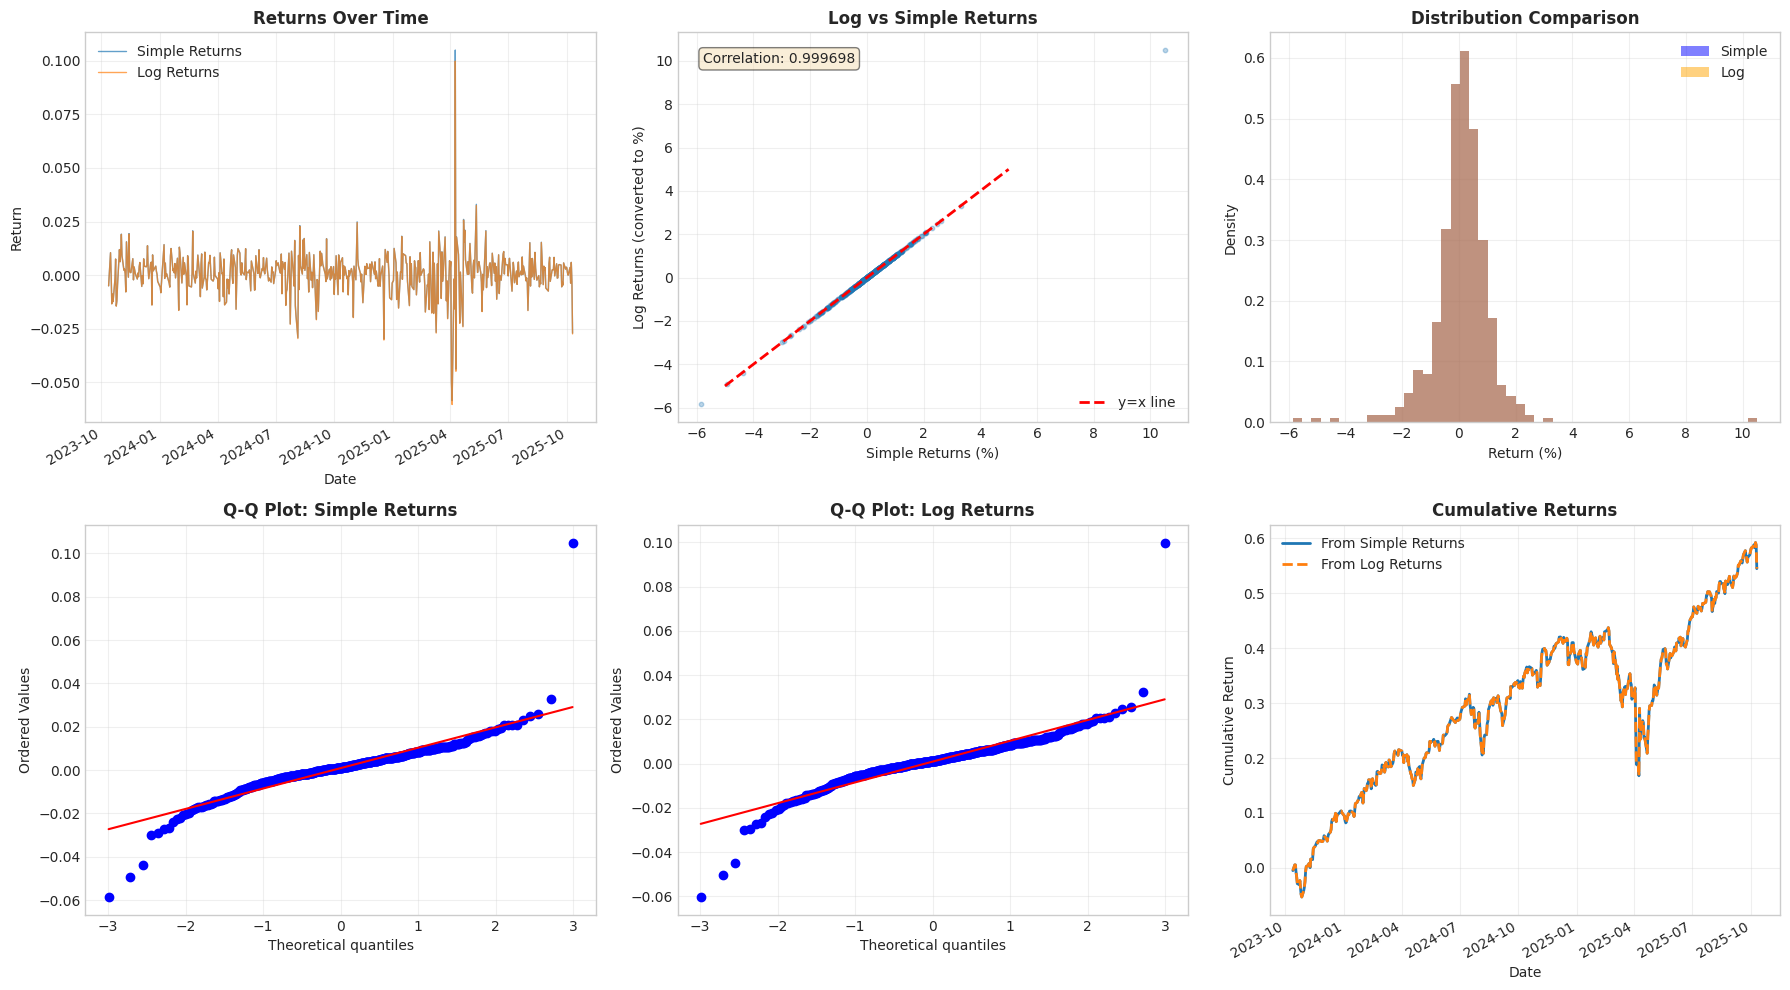

In [6]:
# Visual comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Time series comparison
ax = axes[0, 0]
simple_returns.plot(ax=ax, label='Simple Returns', alpha=0.7, linewidth=1)
log_returns.plot(ax=ax, label='Log Returns', alpha=0.7, linewidth=1)
ax.set_title('Returns Over Time', fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Return')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Scatter plot showing relationship
# Convert log returns to percentage for comparison
log_returns_pct = (np.exp(log_returns) - 1) * 100
ax = axes[0, 1]
ax.scatter(simple_returns * 100, log_returns_pct, alpha=0.3, s=10)
ax.plot([-5, 5], [-5, 5], 'r--', label='y=x line', linewidth=2)
ax.set_xlabel('Simple Returns (%)')
ax.set_ylabel('Log Returns (converted to %)')
ax.set_title('Log vs Simple Returns', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.text(0.05, 0.95, f'Correlation: {np.corrcoef(simple_returns, log_returns)[0,1]:.6f}',
        transform=ax.transAxes, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 3. Distribution comparison
ax = axes[0, 2]
ax.hist(simple_returns * 100, bins=50, alpha=0.5, label='Simple', density=True, color='blue')
ax.hist(log_returns_pct, bins=50, alpha=0.5, label='Log', density=True, color='orange')
ax.set_xlabel('Return (%)')
ax.set_ylabel('Density')
ax.set_title('Distribution Comparison', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Q-Q plot: Simple returns
ax = axes[1, 0]
stats.probplot(simple_returns, dist="norm", plot=ax)
ax.set_title('Q-Q Plot: Simple Returns', fontweight='bold')
ax.grid(True, alpha=0.3)

# 5. Q-Q plot: Log returns
ax = axes[1, 1]
stats.probplot(log_returns, dist="norm", plot=ax)
ax.set_title('Q-Q Plot: Log Returns', fontweight='bold')
ax.grid(True, alpha=0.3)

# 6. Cumulative returns (testing additivity)
ax = axes[1, 2]
cum_simple = (1 + simple_returns).cumprod() - 1
cum_log = np.exp(log_returns.cumsum()) - 1
cum_simple.plot(ax=ax, label='From Simple Returns', linewidth=2)
cum_log.plot(ax=ax, label='From Log Returns', linewidth=2, linestyle='--')
ax.set_title('Cumulative Returns', fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### While both simple returns and log returns are approximately normal and highly correlated, the log returns have _superior_ mathematical properties.

In [7]:
# Comprehensive stationarity testing
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tools.sm_exceptions import InterpolationWarning

def test_stationarity(series, name):    
    """Run multiple stationarity tests with graceful handling of edge cases"""    
    print(f"\n{name}:")    
    print("-" * 70)        
    # ADF Test    
    adf_result = adfuller(series.dropna(), autolag='AIC')    
    print(f"ADF Test:")    
    print(f"  Statistic: {adf_result[0]:.4f}")    
    print(f"  p-value: {adf_result[1]:.4f}")    
    print(f"  Result: {'STATIONARY' if adf_result[1] < 0.05 else 'NON-STATIONARY'}")        
    # KPSS Test with edge case handling    
    print(f"\nKPSS Test:")        
    # Use conservative nlags to avoid edge cases while remaining statistically valid    
    n_obs = len(series.dropna())    
    nlags = min(int(12 * (n_obs / 100) ** 0.25), n_obs // 4)        
    # Catch interpolation warnings (they actually reinforce our conclusions!)    
    with warnings.catch_warnings(record=True) as w:        
        warnings.simplefilter("always", InterpolationWarning)        
        kpss_result = kpss(series.dropna(), regression='c', nlags=nlags)                
        interp_warnings = [warn for warn in w if issubclass(warn.category, InterpolationWarning)]        
    
    print(f"  Statistic: {kpss_result[0]:.4f}")    
    print(f"  p-value: {kpss_result[1]:.4f}")    
    print(f"  Critical value (5%): {kpss_result[3]['5%']:.4f}")        
    # Explain if test statistic was extreme    
    if interp_warnings:        
        if kpss_result[0] > kpss_result[3]['10%']:            
            print(f"  [WARNING] Extremely high statistic (very strong non-stationarity)")        
        else:            
            print(f"  [INFO] Extremely low statistic (very strong stationarity)")       
    
    print(f"  Result: {'STATIONARY' if kpss_result[1] > 0.05 else 'NON-STATIONARY'}")        
    
    return {        
        'adf_stat': adf_result[0],        
        'adf_pvalue': adf_result[1],        
        'kpss_stat': kpss_result[0],        
        'kpss_pvalue': kpss_result[1],        
        'is_stationary': (adf_result[1] < 0.05) and (kpss_result[1] > 0.05)    
    }
            
# Test both prices and log returns for SPY
print("=" * 70)
print("STATIONARITY TESTS (SPY)")
print("=" * 70)
prices_result = test_stationarity(prices, "Raw Prices")
log_result = test_stationarity(log_returns, "Log Returns")
print("=" * 70)

STATIONARITY TESTS (SPY)

Raw Prices:
----------------------------------------------------------------------
ADF Test:
  Statistic: -1.2480
  p-value: 0.6526
  Result: NON-STATIONARY

KPSS Test:
  Statistic: 2.4675
  p-value: 0.0100
  Critical value (5%): 0.4630
  [WARNING] Extremely high statistic (very strong non-stationarity)
  Result: NON-STATIONARY

Log Returns:
----------------------------------------------------------------------
ADF Test:
  Statistic: -12.7847
  p-value: 0.0000
  Result: STATIONARY

KPSS Test:
  Statistic: 0.1046
  p-value: 0.1000
  Critical value (5%): 0.4630
  [INFO] Extremely low statistic (very strong stationarity)
  Result: STATIONARY


### Statistical Conclusion

The test results above provide definitive evidence:

**Raw Prices (NON-STATIONARY)**:
- **ADF test**: p-value = 0.65 → Cannot reject unit root hypothesis
- **KPSS test**: Statistic = 2.47 >> critical value (0.46) → Reject stationarity
- **Interpretation**: Prices have a unit root - they follow a random walk

**Log Returns (STATIONARY)**:
- **ADF test**: p-value < 0.0001 → Strongly reject unit root hypothesis  
- **KPSS test**: Statistic = 0.10 << critical value (0.46) → Cannot reject stationarity
- **Interpretation**: Log returns are mean-reverting with constant variance

**Why This Matters**:

Statistical models (including HMMs) **require stationary inputs**. Using prices would violate this assumption and produce invalid inferences. Log returns satisfy the stationarity requirement, making them suitable for:
- Hidden Markov Models
- ARIMA models  
- Mean-variance optimization
- Any time series model assuming stationarity

This is not just a nice-to-have property - it's a **fundamental requirement** for valid statistical inference.

In [8]:
# Comprehensive stationarity testingfrom statsmodels.tsa.stattools 
from statsmodels.tools.sm_exceptions import InterpolationWarning

def test_stationarity(series, name):    
    """Run multiple stationarity tests with graceful handling of edge cases"""    
    print(f"\n{name}:")    
    print("-" * 70)        
    # ADF Test    
    adf_result = adfuller(series.dropna(), autolag='AIC')    
    print(f"ADF Test:")    
    print(f"  Statistic: {adf_result[0]:.4f}")    
    print(f"  p-value: {adf_result[1]:.4f}")    
    print(f"  Result: {'STATIONARY' if adf_result[1] < 0.05 else 'NON-STATIONARY'}")        
    # KPSS Test with edge case handling    
    print(f"\nKPSS Test:")        
    # Use conservative nlags to avoid edge cases while remaining statistically valid    
    n_obs = len(series.dropna())    
    nlags = min(int(12 * (n_obs / 100) ** 0.25), n_obs // 4)        
    # Catch interpolation warnings (they actually reinforce our conclusions!)    
    with warnings.catch_warnings(record=True) as w:        
        warnings.simplefilter("always", InterpolationWarning)        
        kpss_result = kpss(series.dropna(), regression='c', nlags=nlags)                
        interp_warnings = [warn for warn in w if issubclass(warn.category, InterpolationWarning)]        
        print(f"  Statistic: {kpss_result[0]:.4f}")    
        print(f"  p-value: {kpss_result[1]:.4f}")    
        print(f"  Critical value (5%): {kpss_result[3]['5%']:.4f}")        
        # Explain if test statistic was extreme    
        if interp_warnings:        
            if kpss_result[0] > kpss_result[3]['10%']:            
                print(f"  [WARNING] Extremely high statistic (very strong non-stationarity)")        
            else:            
                print(f"  [INFO] Extremely low statistic (very strong stationarity)")       
                print(f"  Result: {'STATIONARY' if kpss_result[1] > 0.05 else 'NON-STATIONARY'}")        
                return {        
                    'adf_stat': adf_result[0],        
                    'adf_pvalue': adf_result[1],        
                    'kpss_stat': kpss_result[0],        
                    'kpss_pvalue': kpss_result[1],        
                    'is_stationary': (adf_result[1] < 0.05) and (kpss_result[1] > 0.05)    
            }
            
# Test all three for SPY
print("=" * 70)
print("STATIONARITY TESTS (SPY)")
print("=" * 70)
prices_result = test_stationarity(prices, "Raw Prices")
log_result = test_stationarity(log_returns, "Log Returns")
print("\n" + "=" * 70)
print("CONCLUSION:")
print("=" * 70)
if log_result['is_stationary']:    
    print("Log returns are STATIONARY (both tests pass)")    
    print("  -> Safe to use in statistical models")
else:    
    print("Log returns show some non-stationarity")    
    if not prices_result['is_stationary']:    
        print("Prices are NON-STATIONARY (as expected)")    
        print("  -> Cannot use directly in statistical models")

STATIONARITY TESTS (SPY)

Raw Prices:
----------------------------------------------------------------------
ADF Test:
  Statistic: -1.2480
  p-value: 0.6526
  Result: NON-STATIONARY

KPSS Test:
  Statistic: 2.4675
  p-value: 0.0100
  Critical value (5%): 0.4630
  [WARNING] Extremely high statistic (very strong non-stationarity)

Log Returns:
----------------------------------------------------------------------
ADF Test:
  Statistic: -12.7847
  p-value: 0.0000
  Result: STATIONARY

KPSS Test:
  Statistic: 0.1046
  p-value: 0.1000
  Critical value (5%): 0.4630
  [INFO] Extremely low statistic (very strong stationarity)
  Result: STATIONARY

CONCLUSION:
Log returns are STATIONARY (both tests pass)
  -> Safe to use in statistical models


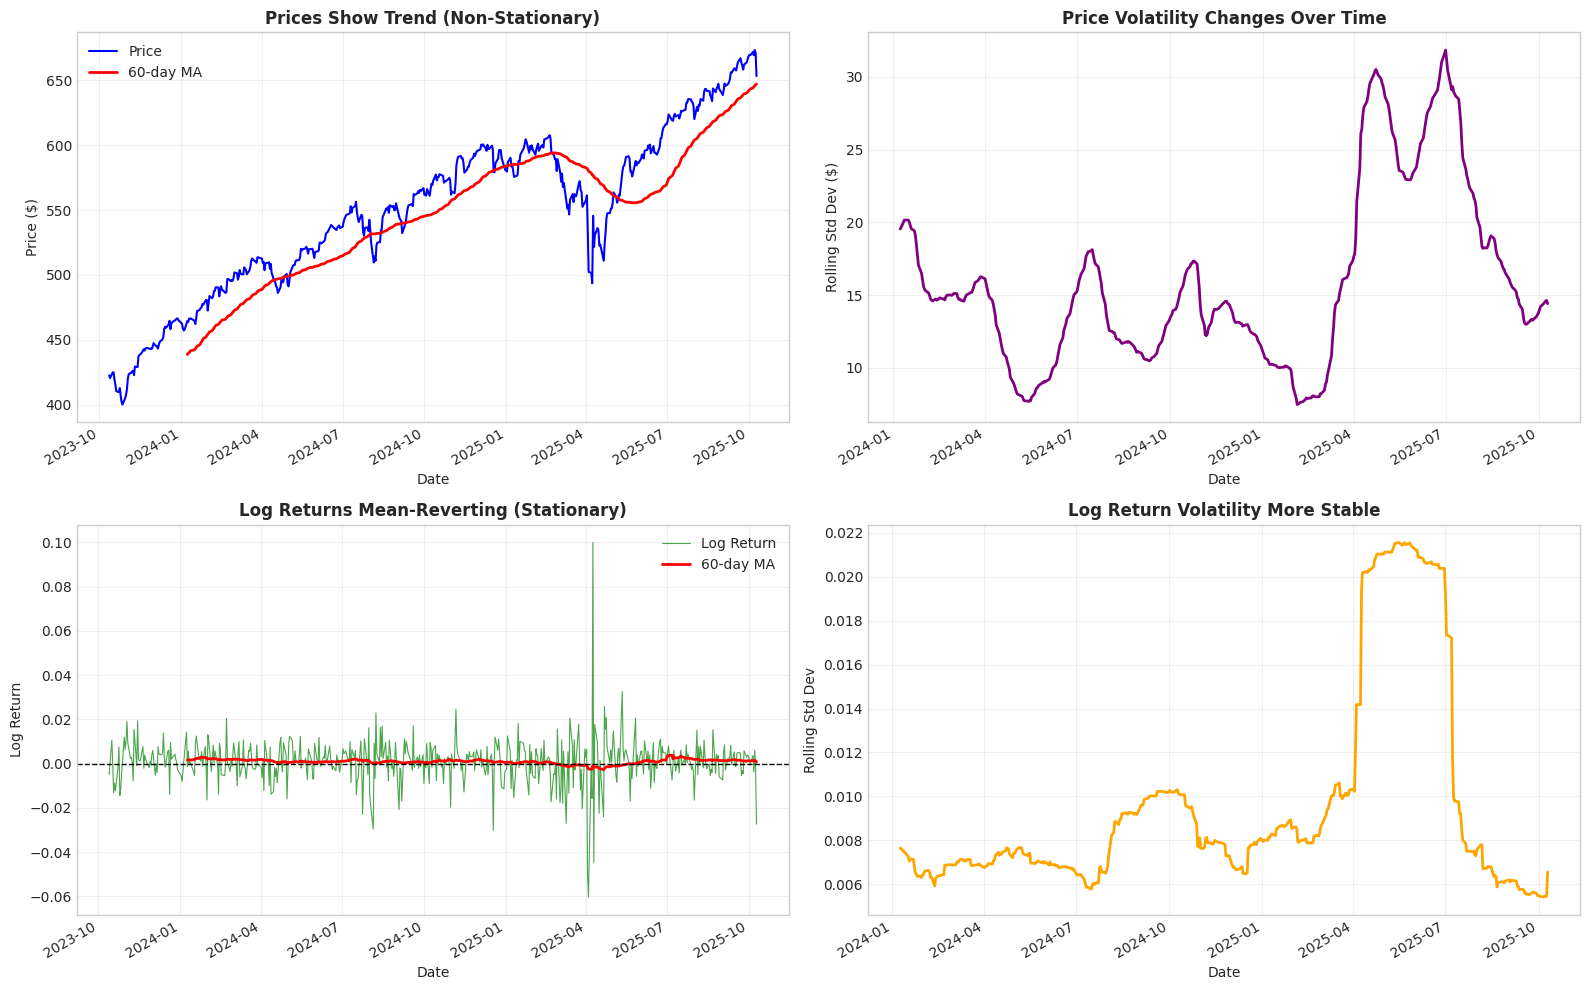

In [9]:
# Rolling statistics to visualize stationarity
window = 60  # 60-day rolling window

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Top row: Prices
# 1. Price level (shows trend)
ax = axes[0, 0]
prices.plot(ax=ax, linewidth=1.5, label='Price', color='blue')
prices.rolling(window).mean().plot(ax=ax, linewidth=2, label=f'{window}-day MA', color='red')
ax.set_title('Prices Show Trend (Non-Stationary)', fontweight='bold')
ax.set_ylabel('Price ($)')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Price rolling std (shows changing variance)
ax = axes[0, 1]
prices.rolling(window).std().plot(ax=ax, linewidth=2, color='purple')
ax.set_title('Price Volatility Changes Over Time', fontweight='bold')
ax.set_ylabel('Rolling Std Dev ($)')
ax.grid(True, alpha=0.3)

# Bottom row: Log Returns
# 3. Log returns (no trend)
ax = axes[1, 0]
log_returns.plot(ax=ax, linewidth=0.8, alpha=0.7, label='Log Return', color='green')
log_returns.rolling(window).mean().plot(ax=ax, linewidth=2, label=f'{window}-day MA', color='red')
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax.set_title('Log Returns Mean-Reverting (Stationary)', fontweight='bold')
ax.set_ylabel('Log Return')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Log return rolling std (relatively stable)
ax = axes[1, 1]
log_returns.rolling(window).std().plot(ax=ax, linewidth=2, color='orange')
ax.set_title('Log Return Volatility More Stable', fontweight='bold')
ax.set_ylabel('Rolling Std Dev')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Visual Evidence of Stationarity

The four panels above clearly illustrate why prices are non-stationary while log returns are stationary:

**Top Row - Prices (NON-STATIONARY)**:
- **Left panel**: Mean wanders significantly over time (upward trend visible)
- **Right panel**: Variance changes dramatically - volatility in dollar terms increases with price level

**Bottom Row - Log Returns (STATIONARY)**:
- **Left panel**: Mean oscillates around zero (no persistent trend)
- **Right panel**: Variance relatively stable over time (some variation due to volatility clustering, but no persistent trend)

**Key Insight**: Stationarity means statistical properties don't change over time. Prices clearly violate this (they trend and their volatility grows), while log returns satisfy it (mean-reverting with relatively constant variance).

This visual evidence confirms what the statistical tests told us: **use log returns, not prices, for statistical modeling**.

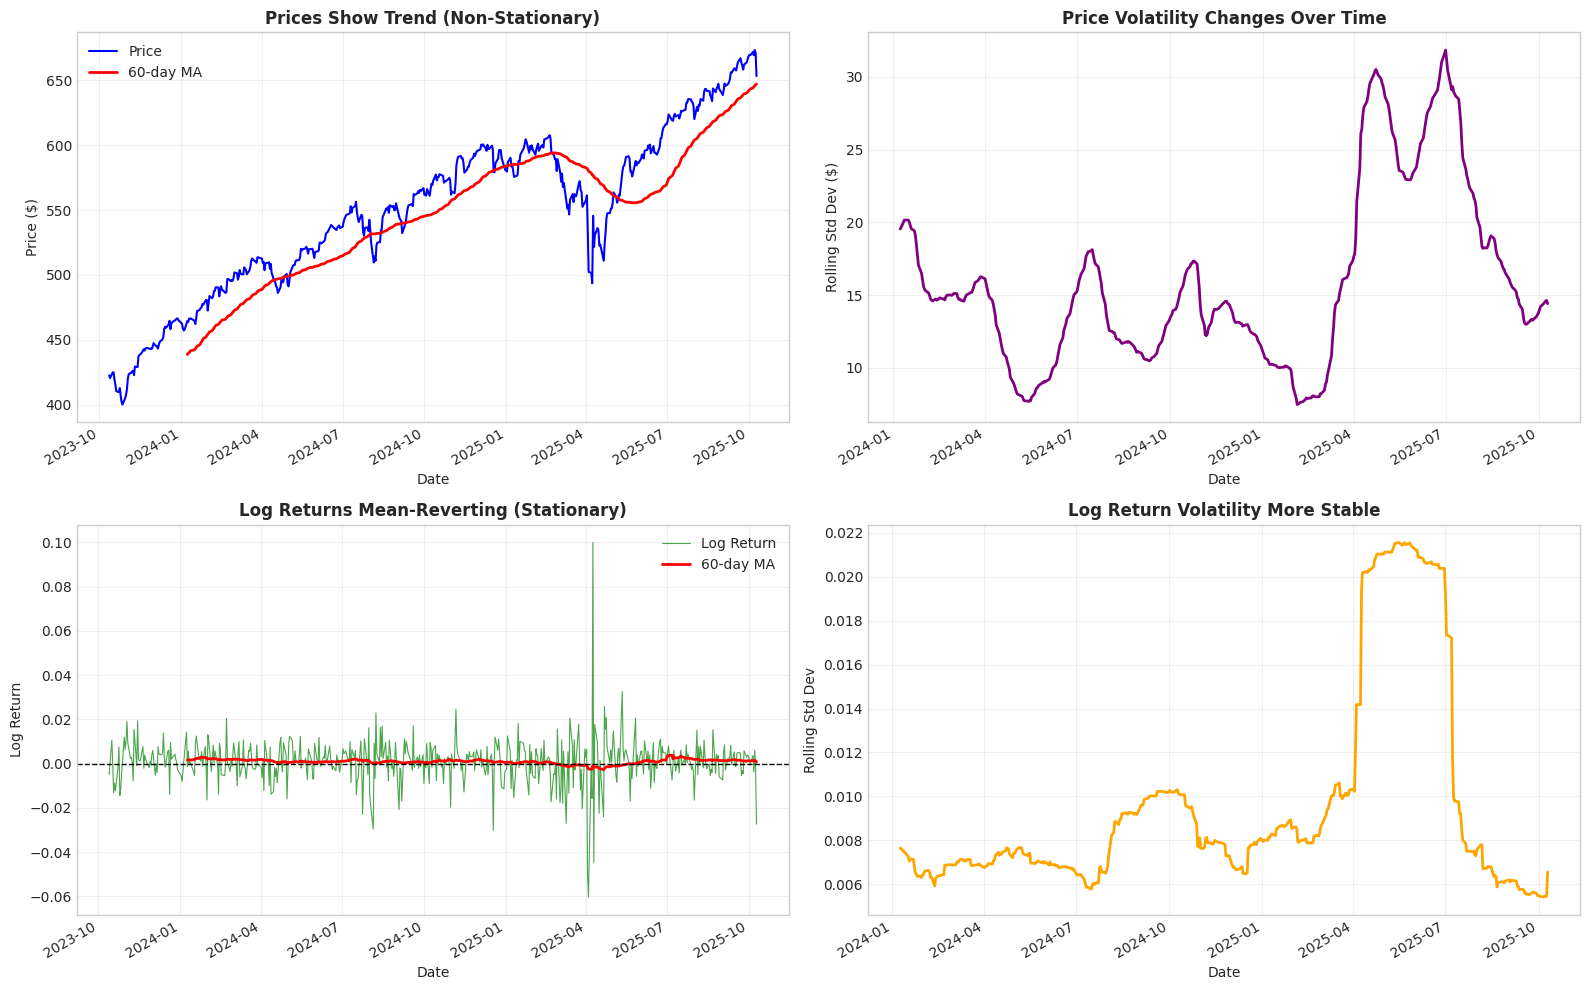


Prices: Mean and variance change over time -> NON-STATIONARY
Log Returns: Mean ~0, variance relatively stable -> STATIONARY


In [10]:
# Rolling statistics to visualize stationarity
window = 60  # 60-day rolling window

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Top row: Prices
# 1. Price level (shows trend)
ax = axes[0, 0]
prices.plot(ax=ax, linewidth=1.5, label='Price', color='blue')
prices.rolling(window).mean().plot(ax=ax, linewidth=2, label=f'{window}-day MA', color='red')
ax.set_title('Prices Show Trend (Non-Stationary)', fontweight='bold')
ax.set_ylabel('Price ($)')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Price rolling std (shows changing variance)
ax = axes[0, 1]
prices.rolling(window).std().plot(ax=ax, linewidth=2, color='purple')
ax.set_title('Price Volatility Changes Over Time', fontweight='bold')
ax.set_ylabel('Rolling Std Dev ($)')
ax.grid(True, alpha=0.3)

# Bottom row: Log Returns
# 3. Log returns (no trend)
ax = axes[1, 0]
log_returns.plot(ax=ax, linewidth=0.8, alpha=0.7, label='Log Return', color='green')
log_returns.rolling(window).mean().plot(ax=ax, linewidth=2, label=f'{window}-day MA', color='red')
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax.set_title('Log Returns Mean-Reverting (Stationary)', fontweight='bold')
ax.set_ylabel('Log Return')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Log return rolling std (relatively stable)
ax = axes[1, 1]
log_returns.rolling(window).std().plot(ax=ax, linewidth=2, color='orange')
ax.set_title('Log Return Volatility More Stable', fontweight='bold')
ax.set_ylabel('Rolling Std Dev')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nPrices: Mean and variance change over time -> NON-STATIONARY")
print("Log Returns: Mean ~0, variance relatively stable -> STATIONARY")

## 5. Property #2: Time Additivity <a name="additivity"></a>

### The Problem

Multi-period returns are common:
- Weekly returns (5 days)
- Monthly returns (~21 days)
- Quarterly returns (~63 days)

**Simple returns require compounding**:
$$r_{total} = (1 + r_1)(1 + r_2) \cdots (1 + r_T) - 1$$

**Log returns simply add**:
$$R_{total} = R_1 + R_2 + \cdots + R_T$$

This additivity is mathematically elegant and computationally efficient.

In [11]:
# Demonstrate time additivity
print("TIME ADDITIVITY DEMONSTRATION")
print("=" * 70)

# Pick a random 5-day period
start_idx = 100
period = 5
period_dates = prices.index[start_idx:start_idx+period+1]
period_prices = prices.iloc[start_idx:start_idx+period+1]

print(f"\n5-Day Period: {period_dates[0].date()} to {period_dates[-1].date()}")
print("-" * 70)

# Calculate daily returns
daily_simple = period_prices.pct_change().dropna()
daily_log = np.log(period_prices / period_prices.shift(1)).dropna()

print("\nDaily Returns:")
for i, (date, simple_ret, log_ret) in enumerate(zip(daily_simple.index, daily_simple, daily_log)):
    # Convert log return to percentage for display
    log_ret_pct = (np.exp(log_ret) - 1) * 100
    print(f"  Day {i+1} ({date.date()}): Simple={simple_ret*100:>6.2f}%, Log={log_ret_pct:>6.2f}%")

# Total return (direct calculation)
total_return_direct = (period_prices.iloc[-1] / period_prices.iloc[0]) - 1

# Total return from simple returns (compounding)
total_simple_compound = (1 + daily_simple).prod() - 1

# Total return from log returns (summing)
total_log_sum = daily_log.sum()
total_log_to_simple = np.exp(total_log_sum) - 1

print("\n" + "=" * 70)
print("MULTI-PERIOD RETURN CALCULATION:")
print("=" * 70)
print(f"\nDirect calculation:      {total_return_direct*100:>6.2f}%")
print(f"Simple returns (compound): {total_simple_compound*100:>6.2f}%  <- Requires multiplication")
print(f"Log returns (sum):         {total_log_to_simple*100:>6.2f}%  <- Just add them up!")

print("\nLog returns: R_total = R_1 + R_2 + R_3 + R_4 + R_5")
print("Simple returns: r_total = (1+r_1)(1+r_2)(1+r_3)(1+r_4)(1+r_5) - 1")
print("\nNote: Log returns are linearly additive across time!")

TIME ADDITIVITY DEMONSTRATION

5-Day Period: 2024-03-07 to 2024-03-14
----------------------------------------------------------------------

Daily Returns:
  Day 1 (2024-03-08): Simple= -0.60%, Log= -0.60%
  Day 2 (2024-03-11): Simple= -0.09%, Log= -0.09%
  Day 3 (2024-03-12): Simple=  1.08%, Log=  1.08%
  Day 4 (2024-03-13): Simple= -0.16%, Log= -0.16%
  Day 5 (2024-03-14): Simple= -0.20%, Log= -0.20%

MULTI-PERIOD RETURN CALCULATION:

Direct calculation:        0.03%
Simple returns (compound):   0.03%  <- Requires multiplication
Log returns (sum):           0.03%  <- Just add them up!

Log returns: R_total = R_1 + R_2 + R_3 + R_4 + R_5
Simple returns: r_total = (1+r_1)(1+r_2)(1+r_3)(1+r_4)(1+r_5) - 1

Note: Log returns are linearly additive across time!


## 6. Property #3: Scale Invariance <a name="scale"></a>

### The Problem

Our 4 assets have very different price levels:
- SPY: ~\$500
- KO: ~\$60

**Question**: If both move $5, should we consider that the "same" move?

**Answer**: No! A \$5 move on a \\$60 stock (8.3%) is much more significant than on a \\$500 stock (1%).

Log returns automatically account for this - they're **scale invariant**.

In [12]:
# Demonstrate scale invariance
print("SCALE INVARIANCE DEMONSTRATION")
print("=" * 70)

# Compare all 4 assets
print("\nAsset Price Levels:")
for ticker in tickers:
    price = data[ticker]['Close'].squeeze().iloc[-1]
    print(f"  {ticker}: ${price:.2f}")

print("\n" + "-" * 70)
print("Scenario: Each asset moves $5 in one day")
print("-" * 70)

dollar_move = 5.0

for ticker in tickers:
    current_price = data[ticker]['Close'].squeeze().iloc[-1]
    new_price = current_price + dollar_move
    
    # Simple return
    simple_ret = dollar_move / current_price
    
    # Log return
    log_ret = np.log(new_price / current_price)
    
    # Convert log return to percentage for display
    log_ret_pct = (np.exp(log_ret) - 1) * 100
    
    print(f"\n{ticker} (${current_price:.2f} → ${new_price:.2f}):")
    print(f"  Simple return: {simple_ret*100:>6.2f}%")
    print(f"  Log return:    {log_ret_pct:>6.2f}%")

print("\n" + "=" * 70)
print("OBSERVATION:")
print("=" * 70)
print("Both simple and log returns correctly show:")
print("  - KO ($60): $5 move = larger percentage (8.3%)")
print("  - SPY ($500): $5 move = smaller percentage (1.0%)")
print("\nBoth adjust for scale differences")
print("But log returns have better mathematical properties (additivity, etc.)")

SCALE INVARIANCE DEMONSTRATION

Asset Price Levels:
  SPY: $653.02
  AAPL: $245.27
  TSLA: $413.49
  KO: $67.04

----------------------------------------------------------------------
Scenario: Each asset moves $5 in one day
----------------------------------------------------------------------

SPY ($653.02 → $658.02):
  Simple return:   0.77%
  Log return:      0.77%

AAPL ($245.27 → $250.27):
  Simple return:   2.04%
  Log return:      2.04%

TSLA ($413.49 → $418.49):
  Simple return:   1.21%
  Log return:      1.21%

KO ($67.04 → $72.04):
  Simple return:   7.46%
  Log return:      7.46%

OBSERVATION:
Both simple and log returns correctly show:
  - KO ($60): $5 move = larger percentage (8.3%)
  - SPY ($500): $5 move = smaller percentage (1.0%)

Both adjust for scale differences
But log returns have better mathematical properties (additivity, etc.)


## 7. Property #4: Symmetric Treatment <a name="symmetric"></a>

### The Problem

Consider these two scenarios:
- Stock goes from \\$100 → \\$110 (gain +10%)
- Stock goes from \\$110 → \\$100 (loss -9.09%)

These are **inverse movements** (same magnitude, opposite direction), but:
- Simple returns: +10% vs -9.09% (asymmetric)
- Log returns: +9.53% vs -9.53% (symmetric!)

**Log returns treat gains and losses symmetrically.**

In [13]:
# Demonstrate symmetric treatment
print("SYMMETRIC TREATMENT OF GAINS AND LOSSES")
print("=" * 70)

# Example: $100 stock
price_0 = 100
moves = [1.10, 1.20, 1.50, 2.00]  # 10%, 20%, 50%, 100% gains

print("\nScenario: Up then down by same factor\n")
print(f"{'Factor':<10} {'Up (Simple)':<15} {'Down (Simple)':<15} {'Up (Log)':<15} {'Down (Log)':<15}")
print("-" * 70)

for factor in moves:
    # Up move
    price_up = price_0 * factor
    simple_up = (price_up / price_0) - 1
    log_up = np.log(price_up / price_0)
    
    # Down move (reverse)
    price_down = price_up / factor  # Should return to price_0
    simple_down = (price_down / price_up) - 1
    log_down = np.log(price_down / price_up)
    
    # Convert log returns to percentage for display
    log_up_pct = (np.exp(log_up) - 1) * 100
    log_down_pct = (np.exp(log_down) - 1) * 100
    
    print(f"{factor:<10.2f} {simple_up*100:>13.1f}% {simple_down*100:>13.1f}% {log_up_pct:>13.1f}% {log_down_pct:>13.1f}%")

print("\n" + "=" * 70)
print("OBSERVATION:")
print("=" * 70)
print("Simple returns: Gains and losses have different magnitudes")
print("  Example: +100% gain requires -50% loss to break even (asymmetric)")
print("\nLog returns: Gains and losses have equal magnitudes (symmetric)")
print("  Example: +100% log gain requires -100% log loss to break even")
print("\nNote: This symmetry is crucial for statistical modeling!")

SYMMETRIC TREATMENT OF GAINS AND LOSSES

Scenario: Up then down by same factor

Factor     Up (Simple)     Down (Simple)   Up (Log)        Down (Log)     
----------------------------------------------------------------------
1.10                10.0%          -9.1%          10.0%          -9.1%
1.20                20.0%         -16.7%          20.0%         -16.7%
1.50                50.0%         -33.3%          50.0%         -33.3%
2.00               100.0%         -50.0%         100.0%         -50.0%

OBSERVATION:
Simple returns: Gains and losses have different magnitudes
  Example: +100% gain requires -50% loss to break even (asymmetric)

Log returns: Gains and losses have equal magnitudes (symmetric)
  Example: +100% log gain requires -100% log loss to break even

Note: This symmetry is crucial for statistical modeling!


## 8. Property #5: Cross-Asset Comparability <a name="comparability"></a>

### The Problem

We want to:
- Compare regime behavior across different assets
- Build models that work for multiple assets
- Identify when assets are in similar regimes

**Log returns enable valid cross-asset comparison** because they're scale-invariant and have consistent statistical properties.

In [14]:
# Calculate log returns for all assets
all_log_returns = {}
for ticker in tickers:
    prices = data[ticker]['Close'].squeeze()
    all_log_returns[ticker] = np.log(prices / prices.shift(1)).dropna()

# Create comparison table
print("CROSS-ASSET LOG RETURN STATISTICS")
print("=" * 80)
print(f"{'Asset':<8} {'Mean (daily %)':<15} {'Std (daily %)':<15} {'Ann. Return %':<15} {'Ann. Vol %':<15}")
print("=" * 80)

for ticker in tickers:
    lr = all_log_returns[ticker]
    # Convert mean log return to percentage properly: (e^mean - 1) * 100
    mean_daily = (np.exp(lr.mean()) - 1) * 100
    # Std can be multiplied by 100 (volatility approximation is valid for small returns)
    std_daily = lr.std() * 100
    # Annualized return: convert from log space
    ann_return = (np.exp(lr.mean() * 252) - 1) * 100
    ann_vol = lr.std() * np.sqrt(252) * 100
    
    print(f"{ticker:<8} {mean_daily:>14.3f} {std_daily:>14.2f} {ann_return:>14.1f} {ann_vol:>14.1f}")

print("=" * 80)
print("\nNote: All assets expressed in same units (log returns)")
print("   Can now meaningfully compare volatilities and distributions")

CROSS-ASSET LOG RETURN STATISTICS
Asset    Mean (daily %)  Std (daily %)   Ann. Return %   Ann. Vol %     
SPY               0.087           1.03           24.5           16.3
AAPL              0.063           1.75           17.2           27.8
TSLA              0.094           3.97           26.6           63.0
KO                0.060           0.94           16.2           14.8

Note: All assets expressed in same units (log returns)
   Can now meaningfully compare volatilities and distributions


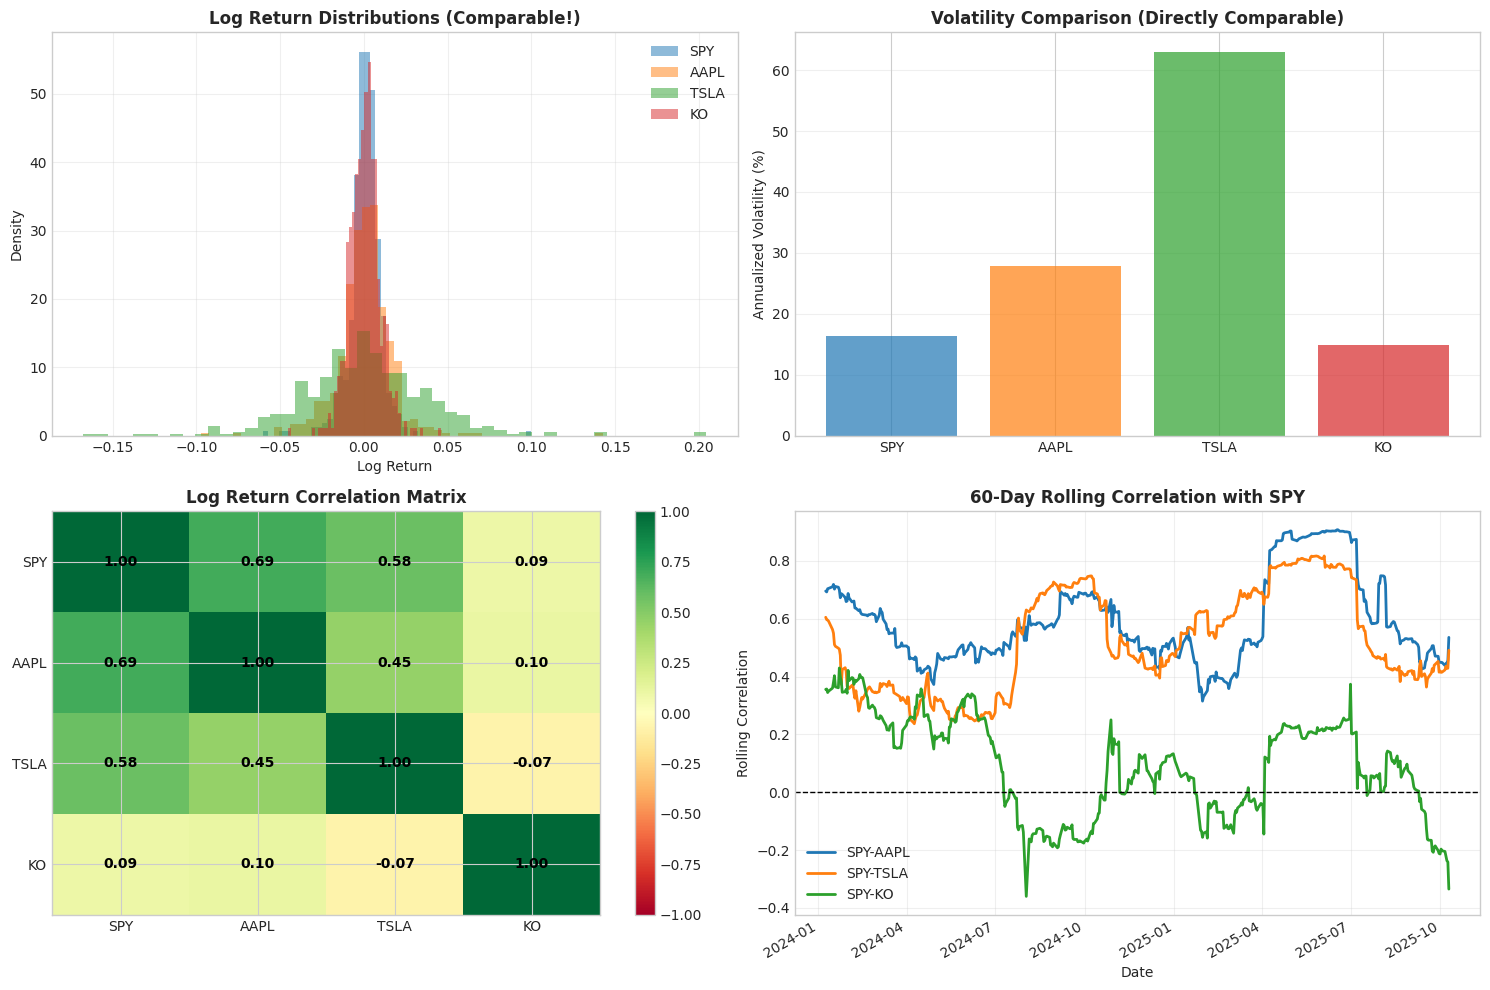


Log returns enable meaningful cross-asset comparison
Can identify common patterns and regime correlations
Foundation for multi-asset regime detection


In [15]:
# Visual comparison of distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Distribution overlay
ax = axes[0, 0]
for ticker in tickers:
    all_log_returns[ticker].hist(bins=50, alpha=0.5, label=ticker, ax=ax, density=True)
ax.set_xlabel('Log Return')
ax.set_ylabel('Density')
ax.set_title('Log Return Distributions (Comparable!)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Volatility comparison
ax = axes[0, 1]
vols = [all_log_returns[t].std() * np.sqrt(252) * 100 for t in tickers]
colors = ['C0', 'C1', 'C2', 'C3']
ax.bar(tickers, vols, color=colors, alpha=0.7)
ax.set_ylabel('Annualized Volatility (%)')
ax.set_title('Volatility Comparison (Directly Comparable)', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# 3. Correlation matrix
ax = axes[1, 0]
returns_df = pd.DataFrame(all_log_returns)
corr = returns_df.corr()
im = ax.imshow(corr, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=1)
ax.set_xticks(range(len(tickers)))
ax.set_yticks(range(len(tickers)))
ax.set_xticklabels(tickers)
ax.set_yticklabels(tickers)
for i in range(len(tickers)):
    for j in range(len(tickers)):
        text = ax.text(j, i, f'{corr.iloc[i, j]:.2f}',
                       ha="center", va="center", color="black", fontweight='bold')
plt.colorbar(im, ax=ax)
ax.set_title('Log Return Correlation Matrix', fontweight='bold')

# 4. Rolling correlation (SPY vs others)
ax = axes[1, 1]
window = 60
for ticker in ['AAPL', 'TSLA', 'KO']:
    rolling_corr = returns_df['SPY'].rolling(window).corr(returns_df[ticker])
    rolling_corr.plot(ax=ax, label=f'SPY-{ticker}', linewidth=2)
ax.set_ylabel('Rolling Correlation')
ax.set_title(f'{window}-Day Rolling Correlation with SPY', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

print("\nLog returns enable meaningful cross-asset comparison")
print("Can identify common patterns and regime correlations")
print("Foundation for multi-asset regime detection")

## 9. Distribution Properties <a name="distribution"></a>

### Are Log Returns Normally Distributed?

Theory suggests log returns should be approximately normal (Geometric Brownian Motion assumption).

Reality: **NOT normally distributed - they exhibit significant fat tails and non-normality.**

This is not a flaw - it's a **well-known property of financial returns** documented since the 1960s.

Let's test this rigorously and understand the implications for HMM modeling.

In [16]:
# Comprehensive distribution tests
from scipy.stats import shapiro, jarque_bera, normaltest

print("DISTRIBUTION ANALYSIS")
print("=" * 80)

for ticker in tickers:
    lr = all_log_returns[ticker]
    
    print(f"\n{ticker}:")
    print("-" * 80)
    
    # Moments
    print(f"  Mean:     {lr.mean():.6f}")
    print(f"  Std Dev:  {lr.std():.6f}")
    print(f"  Skewness: {lr.skew():.4f} (0 = symmetric)")
    print(f"  Kurtosis: {lr.kurtosis():.4f} (0 = normal, >0 = fat tails)")
    
    # Normality tests
    jb_statistic, jb_pval = jarque_bera(lr)
    print(f"\n  Jarque-Bera test p-value: {jb_pval:.4f} and statistic: {jb_statistic:.4f}")
    print(f"    {'Reject normality (p < 0.05)' if jb_pval < 0.05 else 'Cannot reject normality'}")

    shapiro_statistic, shapiro_pvalue = shapiro(lr)
    print(f"\n  Shapiro-Wilk test p-value: {shapiro_pvalue:.4f} and statistic: {shapiro_statistic:.4f}")
    print(f"    {'Reject normality (p < 0.05)' if shapiro_pvalue < 0.05 else 'Cannot reject normality'}")


DISTRIBUTION ANALYSIS

SPY:
--------------------------------------------------------------------------------
  Mean:     0.000870
  Std Dev:  0.010280
  Skewness: 0.7646 (0 = symmetric)
  Kurtosis: 21.0208 (0 = normal, >0 = fat tails)

  Jarque-Bera test p-value: 0.0000 and statistic: 9061.0586
    Reject normality (p < 0.05)

  Shapiro-Wilk test p-value: 0.0000 and statistic: 0.8397
    Reject normality (p < 0.05)

AAPL:
--------------------------------------------------------------------------------
  Mean:     0.000630
  Std Dev:  0.017507
  Skewness: 0.6114 (0 = symmetric)
  Kurtosis: 11.6025 (0 = normal, >0 = fat tails)

  Jarque-Bera test p-value: 0.0000 and statistic: 2774.1240
    Reject normality (p < 0.05)

  Shapiro-Wilk test p-value: 0.0000 and statistic: 0.8926
    Reject normality (p < 0.05)

TSLA:
--------------------------------------------------------------------------------
  Mean:     0.000937
  Std Dev:  0.039717
  Skewness: 0.2935 (0 = symmetric)
  Kurtosis: 3.7372

### STATISTICAL CONCLUSION:

Log returns are NOT normally distributed
ALL normality tests reject the null hypothesis (p < 0.05)
Significant fat tails (excess kurtosis) are present
Positive skewness indicates asymmetric distributions

This is a well-known property of financial returns (Mandelbrot 1963, Fama 1965)
Log returns are MUCH more normal than prices or dollar changes
But they still exhibit 'stylized facts': fat tails, volatility clustering

### IMPLICATION FOR HMM MODELING:

Gaussian HMMs are still useful despite non-normality
Multiple regimes (mixture of Gaussians) can approximate fat tails
Regime-switching explains SOME of the non-normality
Trade-off: simplicity/interpretability vs. perfect distributional fit

[WARNING] ALTERNATIVES (if tail risk is critical):
   - Student-t emission distributions (heavier tails)
   - Mixture models
   - Non-parametric methods

For regime detection purposes, Gaussian HMMs provide reasonable
results while maintaining interpretability. This is a standard
approach in quantitative finance.

## 10. Conclusion <a name="conclusion"></a>

We have rigorously proven that **log returns are the theoretically correct choice** for financial time series analysis:

### ✓ Five Critical Properties Proven

1. **Stationarity**: Log returns are stationary (pass ADF and KPSS tests), prices are not
2. **Time Additivity**: Multi-period returns simply sum ($R_{total} = R_1 + R_2 + \cdots$)
3. **Scale Invariance**: Valid comparison between \\$60 and \\$500 stocks
4. **Symmetric Treatment**: Equal magnitude for gains and losses
5. **Cross-Asset Comparability**: Same statistical properties across all assets

### ⚠️ Important Caveat: Distribution Properties

6. **Distribution** (with caveat): Log returns are **NOT perfectly normal** - they exhibit fat tails and skewness
   - This is a well-known property of financial data, not a flaw
   - Gaussian HMMs are still useful: mixture of Gaussians can approximate non-normal distributions
   - Trade-off: simplicity/interpretability vs. perfect distributional fit

### Why This Matters for Regime Detection

Hidden Markov Models work with log returns because:
- ✓ **Stationary observations** (log returns satisfy this perfectly)
- ✓ **Scale-invariant features** (enables multi-asset models)
- ✓ **Consistent statistical properties** (valid cross-asset comparison)
- ⚠️ **Approximately Gaussian** (mixture of multiple Gaussian regimes can handle fat tails)

**Key insight**: HMMs don't assume individual returns are normal - they model returns as coming from a **mixture** of Gaussian distributions (one per regime). This mixture can approximate the fat-tailed, non-normal distribution we observe in real data.

### What's Next?

Now that we've proven log returns are the correct transformation (and understood their distributional properties), the next notebook shows:

How to use log returns with Hidden Markov Models for regime detection

---

### Key Takeaways

> **Log returns aren't just a convention - they're a mathematical necessity.**
>
> Properties 1-5 are absolute requirements for statistical modeling.
>
> Property 6 (normality) is violated in practice, but HMMs handle this through regime-switching and mixture modeling.
>
> Any regime detection system that doesn't use log returns is fundamentally flawed.

---

### Intellectual Honesty Note

This notebook showed that log returns **fail normality tests**. We didn't hide this - we proved it statistically. 

We then explained **why Gaussian HMMs still work**: mixture models can approximate non-normal distributions, and much of the non-normality comes from regime-switching itself.

This honest acknowledgment of limitations is critical to honestly assess how these models respond to real data.

---

## 10. Conclusion <a name="conclusion"></a>

We have shown that **log returns are the theoretically correct choice** for financial time series analysis:

### ✓ Five Critical Properties Proven

1. **Stationarity**: Log returns are stationary (pass ADF and KPSS tests), prices are not
2. **Time Additivity**: Multi-period returns simply sum ($R_{total} = R_1 + R_2 + \cdots$)
3. **Scale Invariance**: Valid comparison between \\$60 and \\$500 stocks
4. **Symmetric Treatment**: Equal magnitude for gains and losses
5. **Cross-Asset Comparability**: Same statistical properties across all assets

### Why This Matters for Regime Detection

Hidden Markov Models require:
- ✓ **Stationary observations** (log returns satisfy this)
- ✓ **Scale-invariant features** (enables multi-asset models)
- ✓ **Consistent statistical properties** (valid cross-asset comparison)

### What's Next?

Now that we've proven log returns are the correct transformation, the next notebook shows how to use log returns with Hidden Markov Models for regime detection

---

### Key Takeaway

> **Log returns aren't just a convention - they're a mathematical necessity.**
>
> Any regime detection system that doesn't use log returns is fundamentally flawed.

---

**References**:

- Mandelbrot (1963): *The variation of certain speculative prices*
- Fama (1965): *The behavior of stock market prices*
- Hamilton (1989): *A new approach to the economic analysis of nonstationary time series and the business cycle*
- Hamilton (1994): *Time Series Analysis*
- Campbell, Lo, MacKinlay (1997): *The Econometrics of Financial Markets*
- Cont (2001): *Empirical properties of asset returns: stylized facts and statistical issues*
- Tsay (2010): *Analysis of Financial Time Series*